# Llama 3.2 1B Evaluation
Ryan Roi Cayas\
2022-22085

In this notebook, we replicate the published scores of the Llama 3.2 1B on the MATH dataset.

## Prerequisites

In [12]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from tqdm import tqdm
from IPython.display import Latex, display #display LaTeX

import numpy as np
import pandas as pd
import torch
import re

from datasets import load_dataset
from torch.utils.data import DataLoader

from transformers import LlamaForCausalLM, PreTrainedTokenizerFast # load the model and tokenizer

In [8]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
# use a specific GPU
os.environ["CUDA_VISIBLE_DEVICES"]="4"

## Load the MATH dataset

In [3]:
math_dataset_test = load_dataset('competition_math', split='test')
math_dataset_test.to_pandas().head()

,problem,level,type,solution
0,How many vertical asymptotes does the graph of...,Level 3,Algebra,The denominator of the rational function facto...
1,What is the positive difference between $120\%...,Level 1,Algebra,One hundred twenty percent of 30 is $120\cdot3...
2,Find $x$ such that $\lceil x \rceil + x = \dfr...,Level 4,Algebra,"First, we note that $x$ must be positive, sinc..."
3,Evaluate $i^5+i^{-25}+i^{45}$.,Level 5,Algebra,We have $i^5 = i^4\cdot i = 1\cdot (i) = i$. ...
4,"If $2^8=4^x$, what is the value of $x$?",Level 1,Algebra,Rewrite $4$ as $2^2$ to find $4^x=2^{2x}$. Si...


In [16]:
print("Problem:",math_dataset_test[0]['problem'])
print("Level:",math_dataset_test[0]['level'])
print("Type:",math_dataset_test[0]['type'])
print("Solution:",math_dataset_test[0]['solution'])

Problem: How many vertical asymptotes does the graph of $y=\frac{2}{x^2+x-6}$ have?
Level: Level 3
Type: Algebra
Solution: The denominator of the rational function factors into $x^2+x-6=(x-2)(x+3)$. Since the numerator is always nonzero, there is a vertical asymptote whenever the denominator is $0$, which occurs for $x = 2$ and $x = -3$.  Therefore, the graph has $\boxed{2}$ vertical asymptotes.


## Load Llama 3.2B 1B Instruct Model and Tokenizer

In [6]:
# Use GPU for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device being used
print(f"Using device: {device}")

# Check the GPU name
if device.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)  # 0 because CUDA_VISIBLE_DEVICES=4 means GPU 4 is now 0
    print("Using GPU:", gpu_name)

Using device: cuda
Using GPU: NVIDIA A100-SXM4-40GB


In [10]:
# Paths to model and tokenizer
model_dir = "../../../../../llm/llama/Llama-3.2-1B-Instruct"

# Load tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_dir)

# Set the eos_token as the padding token
tokenizer.pad_token = tokenizer.eos_token

# Load model
model = LlamaForCausalLM.from_pretrained(model_dir, 
                                         low_cpu_mem_usage=True, 
                                         torch_dtype='auto'
                                         )

# Move the model to the GPU
model.to(device)

# Set the model to evaluation mode
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

## Sample model inference using a problem from the MATH dataset

In [20]:
# Select a problem from the dataset
sample_index = 5  # Change this index to choose a different problem
sample_problem = math_dataset_test[sample_index]['problem']

print("Problem:", sample_problem)

# Tokenize the input problem
inputs = tokenizer(sample_problem, return_tensors="pt").to(device)  # Move tokens to (GPU) device

# Generate output from the model
with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=2048) 
        # see https://huggingface.co/datasets/meta-llama/Llama-3.2-1B-Instruct-evals/viewer/Llama-3.2-1B-Instruct-evals__math__details
        # max_gen_length: 5120, max_prompt_length: 3072
            #  max_new_tokens: 2048 (max_gen_length - max_prompt_length)

# Decode the generated tokens to text
output_text = tokenizer.decode(output[0], skip_special_tokens=True)

# Print the result
print("Generated Output:\n", output_text)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Problem: What is the 100th term of the arithmetic sequence 6, 10, 14, 18, ...?


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Generated Output:
 What is the 100th term of the arithmetic sequence 6, 10, 14, 18,...??
## Step 1: Identify the first term and the common difference of the arithmetic sequence.
The first term (a) is 6, and the common difference (d) can be found by subtracting the first term from the second term: d = 10 - 6 = 4.

## Step 2: Use the formula for the nth term of an arithmetic sequence to find the 100th term.
The formula for the nth term of an arithmetic sequence is an = a + (n-1)d, where an is the nth term, a is the first term, n is the term number, and d is the common difference.

## Step 3: Substitute the known values into the formula.
a = 6, n = 100, and d = 4. Plugging these values into the formula gives us a = 6 + (100-1)4.

## Step 4: Simplify and calculate the 100th term.
a = 6 + (99)4 = 6 + 396 = 402.

The final answer is: $\boxed{402}$


In [21]:
test = r"The results are $\boxed{2}$, $\boxed{3}$, and $\boxed{5}$."
test = r"\boxed{\frac{2\sqrt{53}+53}{53}}"

# Regular expression to find boxed answers
def find_boxed_answers(text):
    # This pattern matches nested braces
    pattern = r'\\boxed{((?:[^{}]|{(?:[^{}]|{[^{}]*})*})*)}'
    boxed_answers = re.findall(pattern, text)
    return boxed_answers

# Print the boxed answers
print("Boxed Answers (Test):", find_boxed_answers(test))
print("Boxed Answer of the Problem:", find_boxed_answers(output_text))

Boxed Answers: ['\\frac{2\\sqrt{53}+53}{53}']


#### Sample with Instructions

To encourage the model to reason out its solution (chain-of-thought prompting), we add additional instructions as a guide.

The prompt used by Meta (for its four-shot prompting) is available at https://huggingface.co/datasets/meta-llama/Llama-3.2-3B-Instruct-evals/viewer/Llama-3.2-3B-Instruct-evals__math__details (permission needed)

BUT since the reported metric score for the MATH dataset is specified to be zero-shot only, we do not include the four example problems and solutions that Meta provided. We only retain the prompt to encourage chain of thought.

In [37]:
# Define the instruction to prepend
instruction = r"['<|start_header_id|>user<|end_header_id|>\n\nSolve the following math problem efficiently and clearly:\n\n- For simple problems (2 steps or fewer):\nProvide a concise solution with minimal explanation.\n\n- For complex problems (3 steps or more):\nUse this step-by-step format:\n\n## Step 1: [Concise description]\n[Brief explanation and calculations]\n\n## Step 2: [Concise description]\n[Brief explanation and calculations]\n\n...\n\nRegardless of the approach, always conclude with:\n\nTherefore, the final answer is: $\\boxed{answer}$. I hope it is correct.\n\nWhere [answer] is just the final number or expression that solves the problem.\n\nProblem: "

sample_index = 5  # Change this index to choose a different problem
sample_problem = math_dataset_test[sample_index]['problem']

# Add the instruction to the problem
sample_input_to_model = f"{instruction} {sample_problem}"
print("Input to Model:\n", sample_input_to_model)

# Tokenize the input problem
inputs = tokenizer(sample_problem, return_tensors="pt").to(device)  # Move tokens to (GPU) device

# Generate output from the model
with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=2048) 
        # see https://huggingface.co/datasets/meta-llama/Llama-3.2-1B-Instruct-evals/viewer/Llama-3.2-1B-Instruct-evals__math__details
        # max_gen_length: 5120, max_prompt_length: 3072
            #  max_new_tokens: 2048 (max_gen_length - max_prompt_length)

# Decode the generated tokens to text
output_text = tokenizer.decode(output[0], skip_special_tokens=True)

# Print the result
print("Generated Output:\n", output_text)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Input to Model:
 ['<|start_header_id|>user<|end_header_id|>\n\nSolve the following math problem efficiently and clearly:\n\n- For simple problems (2 steps or fewer):\nProvide a concise solution with minimal explanation.\n\n- For complex problems (3 steps or more):\nUse this step-by-step format:\n\n## Step 1: [Concise description]\n[Brief explanation and calculations]\n\n## Step 2: [Concise description]\n[Brief explanation and calculations]\n\n...\n\nRegardless of the approach, always conclude with:\n\nTherefore, the final answer is: $\\boxed{answer}$. I hope it is correct.\n\nWhere [answer] is just the final number or expression that solves the problem.\n\nProblem:  What is the 100th term of the arithmetic sequence 6, 10, 14, 18, ...?
Generated Output:
 What is the 100th term of the arithmetic sequence 6, 10, 14, 18,...??
## Step 1: Identify the first term and common difference of the arithmetic sequence.
The first term of the sequence is 6, and the common difference can be found by su

## Load Eval Data from Meta

Available at: https://huggingface.co/datasets/meta-llama/Llama-3.2-3B-Instruct-evals/viewer/Llama-3.2-3B-Instruct-evals__math__details

(NOTE: Need access permission.)

In [22]:
import json
from huggingface_hub import login

# Load token from config.json
with open("config.json") as f:
    config = json.load(f)

hf_token = config["hf_token"]
login(hf_token)
eval_dataset_FROM_META = load_dataset("meta-llama/Llama-3.2-1B-Instruct-evals", "Llama-3.2-1B-Instruct-evals__math__details")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /data/students/ryan/.cache/huggingface/token
Login successful


In [23]:
eval_dataset_FROM_META

DatasetDict({
    latest: Dataset({
        features: ['task_type', 'task_name', 'subtask_name', 'input_question', 'input_choice_list', 'input_final_prompts', 'input_correct_responses', 'output_prediction_text', 'output_parsed_answer', 'output_choice_completions', 'output_choice_negative_log_likelihoods', 'output_metrics', 'is_correct', 'input_question_hash', 'input_final_prompts_hash', 'benchmark_label', 'eval_config'],
        num_rows: 5000
    })
})

In [24]:
eval_dataset_FROM_META_df = eval_dataset_FROM_META['latest'].to_pandas()
eval_dataset_FROM_META_df.head()

,task_type,task_name,subtask_name,input_question,input_choice_list,input_final_prompts,input_correct_responses,output_prediction_text,output_parsed_answer,output_choice_completions,output_choice_negative_log_likelihoods,output_metrics,is_correct,input_question_hash,input_final_prompts_hash,benchmark_label,eval_config
0,Generative,math_chat_new,None,Find the imaginary part of \[(\cos12^\circ+i\s...,None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[0],[## Step 1: Express the given expression in po...,0,None,None,"{'correct_format': 1.0, 'em': 1.0, 'em_maj1@1'...",True,5a2e4b5ae809e4fe13e8e25fedadc00309a38c663a0872...,[adcde01feac66b5a5a928be8804031ffddcb481ef73e4...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307..."
1,Generative,math_chat_new,None,"What is the least, positive four-digit multipl...",None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[1001],[## Step 1: Determine the smallest four-digit ...,1007,None,None,"{'correct_format': 1.0, 'em': 0.0, 'em_maj1@1'...",False,05be5a24c13a7f03934ca04c01bd595e757234538b3118...,[97745be9a6acd60858e258a46fbd4946e2904dd320c6c...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307..."
2,Generative,math_chat_new,None,What is $(1 + 2 \cdot 3 \cdot 4 \cdot 5) \div ...,None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[11],[## Step 1: Calculate the product inside the p...,21.909...,None,None,"{'correct_format': 1.0, 'em': 0.0, 'em_maj1@1'...",False,fc91c2faca18e68429a3ad12d1edcaf5eaa84183506aaf...,[2a840b3673983db48b20ed473579b710ad1f111764425...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307..."
3,Generative,math_chat_new,None,"Two ropes, 18 meters in length and 24 meters i...",None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[6],[## Step 1: Identify the key constraint\nThe p...,1,None,None,"{'correct_format': 1.0, 'em': 0.0, 'em_maj1@1'...",False,9e87e5f82a292976ff7a0503c803bb2fcbb026b1954d59...,[c7952d5c97db4006ebe8fba59bf41c9caa6dc35c59590...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307..."
4,Generative,math_chat_new,None,"In the diagram below, lines $k$ and $\ell$ are...",None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[60],[## Step 1: The problem provides a diagram wi...,30,None,None,"{'correct_format': 1.0, 'em': 0.0, 'em_maj1@1'...",False,30625ff210cf5a08933c65b91f4ff6b36fa1d03087ea1a...,[857c3d7d39e2cef68320fb00d5271b66676ba06244744...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307..."


In [25]:
eval_dataset_FROM_META_df['eval_config'][0] # check eval_config

{'max_gen_len': '5120',
 'max_prompt_len': '3072',
 'num_few_shot': '4',
 'num_generations': '1',
 'prompt_fn': "functools.partial(<function jinja_dialog_format at 0x7fe9828b28c0>, template={'prompt': 'Solve the following math problem efficiently and clearly:\\n\\n- For simple problems (2 steps or fewer):\\nProvide a concise solution with minimal explanation.\\n\\n- For complex problems (3 steps or more):\\nUse this step-by-step format:\\n\\n## Step 1: [Concise description]\\n[Brief explanation and calculations]\\n\\n## Step 2: [Concise description]\\n[Brief explanation and calculations]\\n\\n...\\n\\nRegardless of the approach, always conclude with:\\n\\nTherefore, the final answer is: $\\\\boxed{answer}$. I hope it is correct.\\n\\nWhere [answer] is just the final number or expression that solves the problem.\\n\\nProblem: {{ problem }}\\n', 'answer': '{{ solution }}. I hope it is correct.'}, append_gen_prefix=False)",
 'return_logprobs': 'false',
 'seed': '42',
 'temperature': '0.0'

In [26]:
input_prompt = eval_dataset_FROM_META_df['input_final_prompts'][0] # check added prompts to input
input_prompt = r"{}".format(input_prompt).replace("\\n", "\n") # convert prompt to raw string
print(input_prompt) 

['<|start_header_id|>user<|end_header_id|>

Solve the following math problem efficiently and clearly:

- For simple problems (2 steps or fewer):
Provide a concise solution with minimal explanation.

- For complex problems (3 steps or more):
Use this step-by-step format:

## Step 1: [Concise description]
[Brief explanation and calculations]

## Step 2: [Concise description]
[Brief explanation and calculations]

...

Regardless of the approach, always conclude with:

Therefore, the final answer is: $\\boxed{answer}$. I hope it is correct.

Where [answer] is just the final number or expression that solves the problem.

Problem: Find the domain of the expression $\\frac{\\sqrt{x-2}}{\\sqrt{5-x}}$.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

## Step 1: Consider the expression inside the first square root
The expression inside the first square root is $x-2$, and it must be non-negative. This means that $x-2 \\ge 0$, which simplifies to $x \\ge 2$.

## Step 2: Consider the express

### Investigate matches of downloaded dataset and Meta's eval dataset

We ensure that the problems in our downloaded test set are also in Llama's dataset.

In [27]:
pd.set_option('display.max_colwidth', None)

print("Problem in downloaded test set:",math_dataset_test[0]['problem'])

# Example math problem
math_problem = math_dataset_test[0]['problem']
# How many vertical asymptotes does the graph of $y=\frac{2}{x^2+x-6}$ have?

# Use `str.contains` to search for the problem in the 'problem' column
matching_row = eval_dataset_FROM_META_df[eval_dataset_FROM_META_df['input_question'].str.contains(math_problem, regex=False)]

print("Input question of matching row:",matching_row['input_question'].to_string())

Problem in downloaded test set: How many vertical asymptotes does the graph of $y=\frac{2}{x^2+x-6}$ have?
Input question of matching row: 4290    How many vertical asymptotes does the graph of $y=\frac{2}{x^2+x-6}$ have?


In [28]:
for i, test_problem in enumerate(math_dataset_test):
    # print(f"Problem in downloaded test set {i}:", test_problem['problem'])
    
    # Example math problem
    math_problem = test_problem['problem']
    
    # Use `str.contains` to search for the problem in the 'problem' column
    matching_row = eval_dataset_FROM_META_df[eval_dataset_FROM_META_df['input_question'].str.contains(math_problem, regex=False)]
    
    no_match_count = 0

    # Check if there are no matching rows
    if matching_row.empty:
        print(f"No matching rows found for problem {i}: {math_problem}")
        no_match_count += 1
    # else:
    #     print(f"Matching rows for problem {i}:")
    #     print(matching_row)

print(f"Total number of problems with no matching rows: {no_match_count}")

Total number of problems with no matching rows: 0


### Verify reported accuracy based on Meta's dataset

In [29]:
# Count true in is_correct column
correct_count = eval_dataset_FROM_META['latest'].to_pandas()['is_correct'].value_counts()[True]
print("Accuracy:", correct_count / len(eval_dataset_FROM_META['latest']))

Accuracy: 0.3044


## Evaluate the model on the MATH dataset

https://github.com/meta-llama/llama-models/blob/main/models/llama3_2/eval_details.md

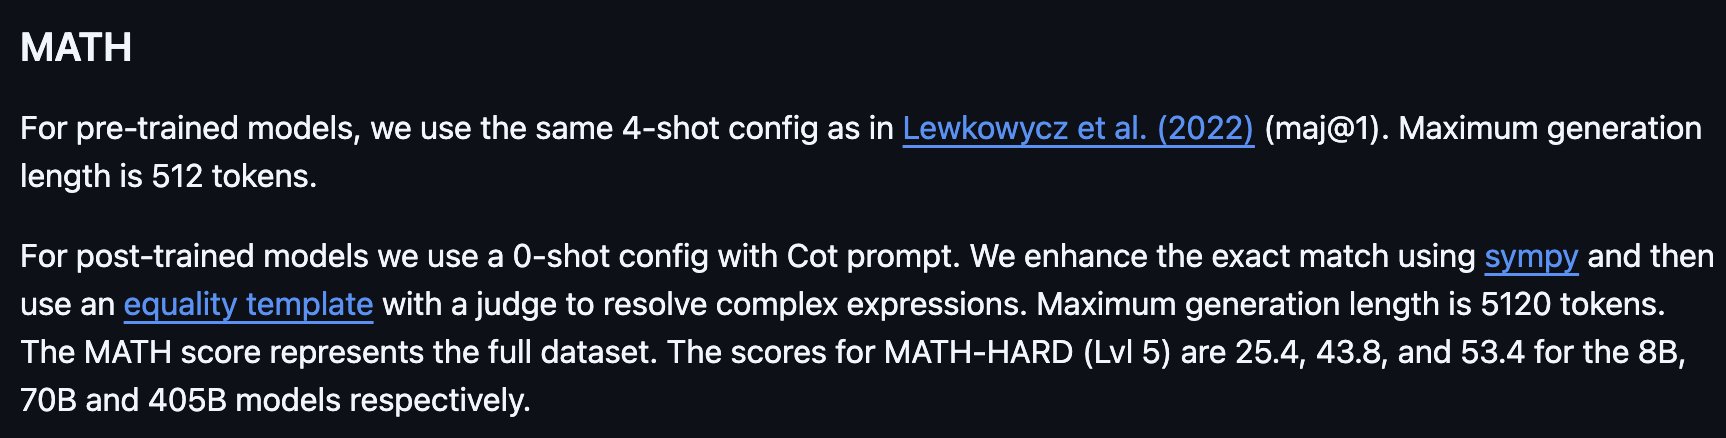

### Extract boxed answers from the solution feature

In [30]:
# Dictionary to store results for each question
results = {}

# Extract boxed answers from the 'solution' feature before evaluation
for index in range(len(math_dataset_test)):
    solution = math_dataset_test[index]['solution']
    boxed_answers_in_solution = find_boxed_answers(solution)

    # Remove duplicates by converting to a set and then back to a list
    boxed_answers_in_solution = list(set(boxed_answers_in_solution))

    # Print message if boxed answer is none or more than one
    if len(boxed_answers_in_solution) == 0:
        print(f"Index: {index}, Boxed Answers: {boxed_answers_in_solution}")
    elif len(boxed_answers_in_solution) > 1:
        print(f"Index: {index}, Boxed Answers: {boxed_answers_in_solution}")

    results[index] = {
        "solution_answers": boxed_answers_in_solution,
        "generated_answers": None,  # Placeholder for later
        "message": None
    }

Index: 91, Boxed Answers: ['\\frac{2\\sqrt{53}+53}{53}', '161']
Index: 333, Boxed Answers: ['-3', '3']
Index: 405, Boxed Answers: ['10\\sqrt{2}', '10\\sqrt 2']
Index: 414, Boxed Answers: ['-2', '1']
Index: 1723, Boxed Answers: ['0.25\\text{ cm}', '0.25\\,\\text{ cm}']
Index: 1984, Boxed Answers: ['\\frac{25}{13}', '1\\frac{12}{13}']
Index: 2037, Boxed Answers: ['\\frac{3}{2}', '\\frac32']
Index: 2152, Boxed Answers: ['5 - 10i', '-3 + 6i', '11']
Index: 2192, Boxed Answers: ['-3\\sqrt5-5', '-3 \\sqrt{5} - 5']
Index: 2549, Boxed Answers: [' -\\tfrac32', '-\\tfrac34']
Index: 2656, Boxed Answers: ['10879', '-10879']
Index: 2703, Boxed Answers: ['\\frac{2}{5}', '3']
Index: 2716, Boxed Answers: ['(0,0)', '(10, 0)']
Index: 2912, Boxed Answers: ['\\left(-\\tfrac52, -\\tfrac52\\right)', '\\left(\\tfrac32, -\\tfrac52\\right)']
Index: 2936, Boxed Answers: ['(0,0)', '(3,-5)']
Index: 3341, Boxed Answers: ['15\\frac{39}{40}', '\\frac{639}{40}']
Index: 3628, Boxed Answers: ['x+11', '11+x']
Index: 3837

In [31]:
math_dataset_test[2716]['solution']

'To find the standard form for the equation of the hyperbola, we move all the terms to one side and then complete the square in both variables: \\[\\begin{aligned} x^2 - 10x - 4y^2 + 5  &= 0 \\\\ (x^2-10x+25) - 4y^2 + 5 &= 25 \\\\ (x-5)^2 - 4y^2 &= 20 \\\\ \\frac{(x-5)^2}{20} - \\frac{y^2}{5} &= 1. \\end{aligned}\\]This fits the standard form of the hyperbola \\[\\frac{(x-h)^2}{a^2} - \\frac{(y-k)^2}{b^2} = 1,\\]where $a=2\\sqrt{5},$ $b=\\sqrt{5},$ $h=5,$ and $k=0.$ Thus, the center of the hyperbola is the point $(h,k)=(5,0).$ Because the $x^2$ coefficient is positive and the $y^2$ coefficient is negative, the foci are horizontally aligned with the center of the hyperbola. We have \\[c = \\sqrt{a^2 + b^2} = \\sqrt{20+5} = 5,\\]which is the distance from the center of the hyperbola to each focus. Therefore, the two foci of the hyperbola are $(5 \\pm 5, 0),$ which gives two points: $\\boxed{(10, 0)}$ and $\\boxed{(0,0)}.$ (Either point is an acceptable answer.)[asy]\nvoid axes(real x0, r

In [32]:
index = 2716
# Example math problem
math_problem = math_dataset_test[index]['problem']
# How many vertical asymptotes does the graph of $y=\frac{2}{x^2+x-6}$ have?

# Use `str.contains` to search for the problem in the 'problem' column
matching_row = eval_dataset_FROM_META_df[eval_dataset_FROM_META_df['input_question'].str.contains(math_problem, regex=False)]

print("Solution of matching row:",matching_row['input_correct_responses'].to_string(index=False))

Solution of matching row: [(0,0)]


#### NOTE: Meta only considers last boxed answer.

In [33]:
def find_last_boxed_answer(text):
    # This pattern matches nested braces
    pattern = r'\\boxed{((?:[^{}]|{(?:[^{}]|{[^{}]*})*})*)}'
    boxed_answers = re.findall(pattern, text)

    if len(boxed_answers) == 0:
        return None
    else:
        return boxed_answers[-1]

In [53]:
# Dictionary to store results for each question
results2 = {}

# Extract boxed answers from the 'solution' feature before evaluation
for index in range(len(math_dataset_test)):
    solution = math_dataset_test[index]['solution']
    boxed_answer_in_solution = find_last_boxed_answer(solution)

    # Print message if no boxed answer is found
    if len(boxed_answer_in_solution) == 0:
        print(f"Index: {index}, Boxed Answers: {boxed_answer_in_solution}")

    results2[index] = {
        "reference_answer": boxed_answer_in_solution,
        "output_text": None,  # Placeholder for later
        "output_seq_length": None,  # Placeholder for later
        "generated_answer": None,  # Placeholder for later
        "message": None # Placeholder for later
    }

### Add initial instructions to each test problem

We prepare for zero-shot CoT prompting by adding the custom prompts used by Meta (discussed above).

In [39]:
# Add the instruction before each problem
def add_instruction(question_set):
    "question set contains 'problem', 'solution', 'type', and 'level'"

    instruction = r"['<|start_header_id|>user<|end_header_id|>\n\nSolve the following math problem efficiently and clearly:\n\n- For simple problems (2 steps or fewer):\nProvide a concise solution with minimal explanation.\n\n- For complex problems (3 steps or more):\nUse this step-by-step format:\n\n## Step 1: [Concise description]\n[Brief explanation and calculations]\n\n## Step 2: [Concise description]\n[Brief explanation and calculations]\n\n...\n\nRegardless of the approach, always conclude with:\n\nTherefore, the final answer is: $\\boxed{answer}$. I hope it is correct.\n\nWhere [answer] is just the final number or expression that solves the problem.\n\nProblem: "

    question_set['problem'] = f"{instruction} {question_set['problem']}"
    return question_set


# Apply the function to the dataset
math_dataset_test = math_dataset_test.map(add_instruction)

# Verify changes by viewing first five problems
math_dataset_test.to_pandas().head()['problem']

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

0                     ['<|start_header_id|>user<|end_header_id|>\n\nSolve the following math problem efficiently and clearly:\n\n- For simple problems (2 steps or fewer):\nProvide a concise solution with minimal explanation.\n\n- For complex problems (3 steps or more):\nUse this step-by-step format:\n\n## Step 1: [Concise description]\n[Brief explanation and calculations]\n\n## Step 2: [Concise description]\n[Brief explanation and calculations]\n\n...\n\nRegardless of the approach, always conclude with:\n\nTherefore, the final answer is: $\\boxed{answer}$. I hope it is correct.\n\nWhere [answer] is just the final number or expression that solves the problem.\n\nProblem:  How many vertical asymptotes does the graph of $y=\frac{2}{x^2+x-6}$ have?
1                       ['<|start_header_id|>user<|end_header_id|>\n\nSolve the following math problem efficiently and clearly:\n\n- For simple problems (2 steps or fewer):\nProvide a concise solution with minimal explanation.\n\n- For complex p

In [52]:
# Count max tokens in the problems
max_tokens = 0

for i in range(len(math_dataset_test)):
    problem = math_dataset_test[i]['problem']
    tokens = tokenizer(problem, return_tensors="pt").input_ids
    max_tokens = max(max_tokens, tokens.shape[1])

print("Max tokens in the problems:", max_tokens)

Max tokens in the problems: 1430


### Generate output solutions for each test set observation

In [55]:
# Parameters for batch processing
batch_size = 100

# Create a DataLoader for the dataset
test_data_loader = DataLoader(math_dataset_test, batch_size=batch_size, shuffle=False)

# Initialize a counter for the question index
question_index = 0

# Iterate over the DataLoader
for batch_samples in tqdm(test_data_loader, total=len(test_data_loader)):
    # Debugging: Print the type and content of batch_samples
    # print(f"Type of batch_samples: {type(batch_samples)}")
    # print(f"Content of batch_samples: {batch_samples}")

    batch_problems = batch_samples['problem']
    
    # Tokenize the input problems
    inputs = tokenizer(batch_problems, return_tensors="pt", padding=True, truncation=True).to(device)

    # Generate outputs from the model for the entire batch
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=3690)
            # max tokens in input problems: 1430
                # max_gen_length: 5120, max_prompt_length: 5120 - 1430 = 3690

    # Process each output in the batch
    for output in outputs:
        # Count the number of tokens in the output
        num_tokens = len(output)
        results2[question_index]["output_seq_length"] = num_tokens

        # Decode the generated tokens to text
        output_text = tokenizer.decode(output, skip_special_tokens=True)

        # Find boxed answers
        boxed_answer = find_last_boxed_answer(output_text)

        # Store results in the dictionary
        if boxed_answer is None:
            results2[question_index]["output_text"] = output_text
            results2[question_index]["generated_answer"] = None
            results2[question_index]["message"] = f"No boxed answer found for question {question_index}."
        else:
            results2[question_index]["output_text"] = output_text
            results2[question_index]["generated_answer"] = boxed_answer
            results2[question_index]["message"] = None
            
        # Increment the question index
        question_index += 1

# Print the results
no_ans_counter = 0
for question_id, result in results2.items():
    if result["message"]:
        print(result["message"])
        no_ans_counter += 1

print(f"Number of questions with no boxed answer: {no_ans_counter}")


100%|██████████| 50/50 [6:33:34<00:00, 472.28s/it]

Number of questions with no boxed answer: 0


In [56]:
# Save results dict to a file in outputs folder
import json

# Create a directory to store the results
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Save the results to a file
results2_file = os.path.join(output_dir, "results2.json")
with open(results2_file, "w") as f:
    json.dump(results2, f)

### Evaluate exact matches

In [57]:
output_dir = "outputs"
results_file = os.path.join(output_dir, "results2.json")

# Load the results from the file
with open(results_file, "r") as f:
   results = json.load(f)

# Check number of questions with no boxed answer
no_ans_counter = 0
for question_id, result in results.items():
    if result["message"]:
        no_ans_counter += 1

print(f"Number of questions with no answer: {no_ans_counter}")

Number of questions with no answer: 0


As per Meta's documentation, exact match was enhanced using sympy and an equality template with a judge. 

The equality template used by Meta can be found here:
https://github.com/openai/simple-evals/blob/main/common.py

For more info, see https://github.com/meta-llama/llama-models/blob/main/models/llama3_2/eval_details.md

In [58]:
EQUALITY_TEMPLATE = r"""
Look at the following two expressions (answers to a math problem) and judge whether they are equivalent. Only perform trivial simplifications

Examples:

    Expression 1: $2x+3$
    Expression 2: $3+2x$

Yes

    Expression 1: 3/2
    Expression 2: 1.5

Yes

    Expression 1: $x^2+2x+1$
    Expression 2: $y^2+2y+1$

No

    Expression 1: $x^2+2x+1$
    Expression 2: $(x+1)^2$

Yes

    Expression 1: 3245/5
    Expression 2: 649

No
(these are actually equal, don't mark them equivalent if you need to do nontrivial simplifications)

    Expression 1: 2/(-3)
    Expression 2: -2/3

Yes
(trivial simplifications are allowed)

    Expression 1: 72 degrees
    Expression 2: 72

Yes
(give benefit of the doubt to units)

    Expression 1: 64
    Expression 2: 64 square feet

Yes
(give benefit of the doubt to units)

---

YOUR TASK


Respond with only "Yes" or "No" (without quotes). Do not include a rationale.

    Expression 1: %(expression1)s
    Expression 2: %(expression2)s
""".strip()

In [69]:
# NEED TO REDO: Extract boxed answers from the 'solution' feature before evaluation
for index in range(len(math_dataset_test)):
    solution = math_dataset_test[index]['solution']
    boxed_answer_in_solution = find_last_boxed_answer(solution)

    # Print message if no boxed answer is found
    if len(boxed_answer_in_solution) == 0:
        print(f"Index: {index}, Boxed Answers: {boxed_answer_in_solution}")

    results[f'{index}']['reference_answer'] = boxed_answer_in_solution
    

In [71]:
import sympy as sp

# Function to judge equality using the template
def judge_equality_llm(expression1, expression2):
    prompt = EQUALITY_TEMPLATE % {"expression1": expression1, "expression2": expression2}
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_new_tokens=10)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    return response

def check_match(generated_answer, reference_answer):
    try:
        # Return False if either value is NoneType
        if generated_answer is None or reference_answer is None:
            return False

        # Direct comparison
        if generated_answer == reference_answer:
            return True
        
        # Convert fractions to numeric format
        generated_expr = sp.sympify(generated_answer)
        reference_expr = sp.sympify(reference_answer)
        
        # Simplify both expressions
        simplified_generated = sp.simplify(generated_expr)
        simplified_reference = sp.simplify(reference_expr)
        
        # Compare the simplified expressions
        if simplified_generated == simplified_reference:
            return True
        else:
            # Pass to LLM to judge equality
            result = judge_equality_llm(simplified_generated, simplified_reference)
            return result == "Yes"
    
    except (sp.SympifyError, TypeError, AttributeError):
        # If parsing or comparison fails, we pass to LLM to judge equality
        result = judge_equality_llm(generated_answer, reference_answer)
        return result == "Yes"

In [75]:
import logging

# Set the logging level to ERROR to suppress warnings
logging.getLogger("transformers").setLevel(logging.ERROR)

correct = 0
for index in tqdm(range(len(math_dataset_test)), desc="Processing"):
    generated_answer = results[f'{index}']["generated_answer"]
    reference_answer = results[f'{index}']["reference_answer"]
    
    is_correct = check_match(generated_answer, reference_answer)
    results[f'{index}']["is_correct"] = is_correct
    
    correct += is_correct

print(f"Number of correct answers: {correct}")
print(f"Accuracy: {correct / len(math_dataset_test)}")

Processing: 100%|██████████| 5000/5000 [08:28<00:00,  9.83it/s]

Number of correct answers: 1143
Accuracy: 0.2286


In [76]:
# Create a directory to store the results
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Save the results to a file
results_checked_file = os.path.join(output_dir, "results_checked.json")
with open(results_checked_file, "w") as f:
    json.dump(results, f)